# Bayesian Networks for Estimating Attack Vector

## Intro & motivating example

Humans are notoriously bad at reasoning about probabilities: more often than not, we rely on cognitive shortcuts (heuristics and biases) instead of actually calculating the liklihood of events. This can be a good thing; just think how paralyzed we would be if we stopped to calculate the probability of rain every time we heard raindrops on our window, rather than just grabbing an umbrella! Even computers can start to run into tractability problems when working with probability distributions involving even a few dozen variables. In this tutorial, we will introduce a tool, called Bayesian networks, for automatically and efficiently reasoning about probabilities. These networks will allow us to ask questions like "given this new evidence, what is the probability of some hidden variable being true" or "what is the most likely explanation for some set of observations?". These questions might remind you of our lectures on Hidden Markov Models (HMMs); it turns out that Bayesian networks can be used to represent Markov processes, but they are much more expressive and can be used to model much more complicated scenarios.

To make this discussion more concrete, it's helpful to have a motivating example. You are a security engineer in the employ of the Generic Galactic Empire aboard a controversial new ~~moon~~ space station. You are aware of several security vulnerabilities in the space station's software subsystems, but you have no way to detect whether those vulnerabilities are being exploited except by running diagnostics on various workstations throughout the station. Since you'd like to be able to detect attacks based on the probability that a vulnerability is being exploited, you'd like an easy way to relate your observations of workstations to the probability of a cyberattack taking place. After a brief review of probability fundamentals, we'll discuss how Bayesian networks can be used to model this situation and make inferences automatically.

### References
The discussion in this tutorial draws heavily from the following sources:
- Russell & Norvig, AIMA, Chapter 13 & 14
- [R. Dechter, "Bucket Elimination: A Unifying Framework for Probabilistic Inference"](https://webdocs.cs.ualberta.ca/~rgreiner/C-366/RG-2002-SLIDES/BucketElim.pdf) 

Chapter 13 of AIMA provides an overview of probability fundamentals, while chapter 14 discusses Bayesian networks in more depth. Dechter's article describes efficient algorithms for making inference based on Bayesian networks.

## Probability Review
- This section won't provide a huge overview of probability, but just a reminder of the relevant parts.
- Random variables and joint probability distributions (for n binary variables, requires 2^n storage)
- Reasoning using joint distributions (13.3)
    - just read out e.g. P(A ^ B)
    - marginalization to get marginal probability e.g. just P(A) = P(A ^ B) + P(A ^ !B) (plus general eq.)
    - Conditional/posterior probabilities, product rule P(A ^ B) = P(A | B)P(B), and conditioning (marginalization but with conditional probs).
    - Derive P(X|e) = P(X^e)/P(e) = aP(X^e) = a \sum_y P(X, e, y) (normalization to get a so that P(X|e)+P(!X|e)=1
    - Remark: this would allow us to answer whatever queries we want to ask just by looking in the joint distribution table. BUT that table has size O(2^n) and requires O(2^n) to process by summing over it.
- Reasoning using conditional distributions (13.4)
    - Lots of redundant information in full joint distribution (like how your toothache affects the weather, ignoring causality)
    - Independence! Conditional independence (based on causality)!
    - Allows factoring the joint distribution into multiple smaller conditional distributions, saving on size. 2^n+2^m << 2^{n+m}    

## Bayesian Networks

Exploiting conditional independence can allow us to reason much more efficiently about joint probabilities, but it would be really nice if we could automate the inference process by encoding conditional probabilities in a convenient data structure. Since dependence relates each variable to a set of "parent" variables, a natural structure is a directed graph, where
- Each node corresponds to an uncertain variable (in this tutorial, we'll restrict ourselves to discrete random variables),
- If variable $B$ is dependent on $A$, then we draw a directed edge from node `A` to node `B` in the graph, and
- Each node $X$ is labelled with its conditional probability distribution $P(X\ |\ \text{Parents}(X))$, which takes the form of a table with a row for each combination of assignments to the parent variables of $X$, specifying the probabilities that $X$ takes on each of its values conditioned on those parent variable assignments.

Since we don't want any variable to depend (directly or indirectly) on itself, this graph must not have any directed cycles (making it a *directed acyclic graph*. An example graph is shown in the figure below. Given this structure, we can see that it directly encodes both independence and conditional independence: sibling nodes (i.e. nodes sharing a parent) are conditionally independent, while nodes in disconnected graphs are independent.

We call this data structure a Bayesian network (or sometimes a *belief network* or *causal network*). These networks can represent any full joint distribution, but depending on the degree to which causal relationships allow us to factor the joint distribution into smaller conditional distributions, Bayesian networks can encode this information much more compactly. In the next example, we'll give a simple example of a Bayesian network and show how we can make inference based on these networks.

### A simple example

Before moving on to the more complicated case of our original motivating problem, we'll use the simpler scenario from Fig. 14.2 in Russel & Norvig to illustrate the key features of Bayesian networks. In this scenario, you've just installed a new alarm in your house, and since you don't want Google spying on your home, you've chosen not to connect the alarm to the internet. Instead, you've asked your neighbors, John and Mary, to listen for the alarm and call you if they hear it going off. Complicating matters, the alarm will go off if a burglary occurs, but it is a little too sensitive and will also go off if an earthquake occurs. In addition, John will will sometimes confuse a telephone ringing for the alarm and call then as well, and because Mary likes listening to loud music, she will sometimes miss the alarm altogether.

In this scenario, we essentially have five uncertain boolean variables:
+ `B`: whether a burglary has occurred,
+ `E`: whether an earthquake has occurred,
+ `A`: whether the alarm has gone off,
+ `J`: whether John calls you, and
+ `M`: whether Mary calls you.

Note that only `J` and `M` are observable. If we were to encode the full joint probability distribution, we'd need to store a table of size $O(2^n) = O(32)$. This is not too large in thi scase, but if you have even 30 variables then the joint distribution table would require $O(4$ GB$)$ of storage, and adding a 31st variable would require another 4 GB! We are clearly on the wrong side of this exponential when it comes to the joint distribution.

To make the problem more tractable, we can exploit the causal relationships between these variables, allowing us to store a handful of smaller conditional distributions rather than a monolithic joint distribution. The causal structure of this problem leads to the Bayesian network shown in the image below (reprinted from Russell & Norvig):

<img src="files/figs/alarm-problem-structure.png">

Since `J` and `M` only depend on `A`, we don't need to explicitly store the effect of an earthquake on the probability of John calling. Instead of a 32-entry joint distribution, we only need to store 20 values in 5 smaller conditional distributions. Only 10 entries are shown here because for boolean variables the probability of a false value is fixed at 1-(the probability of a true value). For scenarios with even more variables, these savings would be even more dramatic.

It's important to note that the Bayesian network representation is not unique: you can order the variables in any way you want and back out the conditional probability tables from the joint distribution. In this case, we have ordered the nodes from causes to effects (causes at the top, flowing down to effects at the bottom of the network). This is a good heuristic for constructing concise Bayesian networks.

We've written classes in `bayes_net.py` implementing the basic functionality of Bayesian networks for you, allowing you to represent these networks programmatically. You should go check out the source code to get an idea of what features are available, and a basic example of constructing a network for this example scenario is given below. To properly load the drawing function, **you must run this cell twice**.

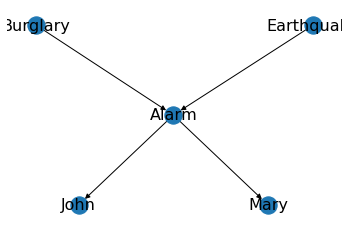

In [2]:
## Example code for constructing the simple burglary example from AIMA (Fig. 14.2)
from bayes_net import BayesNet, BayesNode
import numpy as np
import warnings
# The plotting functionality generates some warnings that aren't too important, so filter them out.
warnings.filterwarnings("ignore", category=UserWarning)

# First, instantiate the two nodes that have no parents in the network.
# The domain of these variables is just {True, False} here, but we support arbitrary discrete domains
burglary_node = BayesNode('Burglary')
burglary_node.set_marginal_distribution({True: 0.001, False: 0.999})
earthquake_node = BayesNode('Earthquake')
earthquake_node.set_marginal_distribution({True: 0.002, False: 0.998})

# Now we can instantiate nodes with probabilities conditioned on their parents
# We have to build the conditional distribution table one entry at a time, for each combination
# of parent variables
alarm_node = BayesNode('Alarm')
alarm_node.add_entry([(burglary_node, True), (earthquake_node, True)], {True: 0.95, False: 0.05})
alarm_node.add_entry([(burglary_node, True), (earthquake_node, False)], {True: 0.94, False: 0.06})
alarm_node.add_entry([(burglary_node, False), (earthquake_node, True)], {True: 0.29, False: 0.71})
alarm_node.add_entry([(burglary_node, False), (earthquake_node, False)], {True: 0.001, False: 0.999})

john_node = BayesNode('John')
john_node.add_entry([(alarm_node, True)], {True: 0.9, False: 0.1})
john_node.add_entry([(alarm_node, False)], {True: 0.05, False: 0.95})

mary_node = BayesNode('Mary')
mary_node.add_entry([(alarm_node, True)], {True: 0.7, False: 0.3})
mary_node.add_entry([(alarm_node, False)], {True: 0.01, False: 0.99})

# Now we can create a BayesNet object to store all the nodes.
alarm_net = BayesNet([burglary_node, earthquake_node, alarm_node, john_node, mary_node])

# As a sanity check, we can visualize the network to make sure it matches our model above.
# If the figure doesn't show up the first time, try again.
alarm_net.draw_net()

### Inference on Bayesian Networks

Now that we've constructed a bayesian network, what can we do with it? First of all, we can use the network to query the full joint probability distribution as well as asking other questions based on joint probabilities.

#### Calculating Joint Probabilities

In general, the joint probability for variable assignments $x_1,\ldots, x_n$ is given by

$$P(x_1,\ldots, x_n) = \prod_{i=1}^n P(x_i\ |\ \text{Parents}(x_i))$$

where we can simply read $P(x_i\ |\ \text{Parents}(x_i)$ out of the conditional distribution attached to node `x_i`. In the context of our specific example, say we want to know the probability `B = True`, `E = False`, `A = True`, `J = True`, `M = True` (the probability that we got a call from John and Mary, the alarm has gone off, there has been a burglary, and there has been no earthquake). Using the general formula above, we get this joint probability as:

$$\begin{align*}
P(M, J, A, not E, B) &= P(M | A) \cdot P(J |A) \cdot P(A | not E, B) \cdot P(not E) \cdot P(B) \\
                     &= 0.7 \cdot 0.9 \cdot 0.94 \cdot 0.998 \cdot 0.001 \\
                     &= 0.00059
\end{align*}$$

This functionality is implemented in the provided `BayesNet` class, which we can query directly as shown below.

In [ ]:
joint_prob = alarm_net.calc_joint([(mary_node, True), 
                                   (john_node, True),
                                   (alarm_node, True),
                                   (earthquake_node, False),
                                   (burglary_node, True)])
print('P(M, J, A, not E, B) = {}'.format(joint_prob))

#### Calculating Posterior Probabilities

With this ability to query the joint distribution, we can answer a broad range of other questions. For instance, if we want to know the posterior probability of some event $X$ after observing some evidence $e$, we can calculate

$$P(X|e) = \alpha P(X, e) = \alpha \sum_{y \notin \{X,e\}} P(X, e, y)$$

where $\alpha$ is a normalization constant set so that $P(X|e) + P(not X|e) = 1$. In our example, if we want to know the probability of a burglary having occured if we receive a call from John and Mary, we can calculate

$$\begin{align*}
P(B|J, M) = \alpha P(B, J, M) &= \alpha \sum_{a \in \{A, not A\}}\sum_{e \in \{E, notE\}} P(B, J, M, a, b, e)
\end{align*}$$

where $P(B, J, M, a, b, e)$ is a joint probability calculated as shown above. Substituting the equation for joint probabilities into this expression, we get 

$$\begin{align*}
P(B | J, M) = \alpha P(B, J, M) &= \alpha \sum_{a \in \{A, not A\}} \sum_{e \in \{E, notE\}} P(B, J, M, a, B, e) \\
                              &= \alpha \sum_{a \in \{A, not A\}}\sum_{e \in \{E, notE\}} P(M | a) \cdot P(J | a) \cdot P(a | e, B) \cdot P(e) \cdot P(B)
\end{align*}$$

This is a convenient feature, but without further optimization it is pretty inefficient: we need to multiply $n$ values for each of $2^n$ combinations of variable assignments, so this method has time complexity $O(n2^n)$, which again puts us on the losing side of an exponential term. We've implemented this brute-force algorithm (as described in AIMA 14.4.1) in the cell below. You can see how it performs on the simple network we've defined above; later, we'll benchmark the performance of this algorithm compared to more efficient algorithms when run on larger networks.

In [ ]:
import itertools

def init_distribution(X):
    """Returns an empty distribution in the form of a nested dictionary, where level i
    has keys corresponding to values of variable x_i in X, along with a list of
    discrete combinations represented in P"""
    P = dict()
    domain_combinations = list(itertools.product(*[list(var.domain) for var in X]))
    # this loop constructs a series of nested dictionaries, where each level corresponds
    # to a variable in X
    for assignments in domain_combinations:
        previous_level = P
        for val in assignments:
            if val not in previous_level:
                next_level = dict()
                previous_level[val] = next_level
                previous_level = next_level
            else:
                previous_level = previous_level[val]
    return P, domain_combinations

def update(distribution, assignment, value):
    """Updates the value for the given assignment in the nested dictionary distribution"""
    head = assignment[0]
    if type(distribution[head]) is not dict:
        distribution[head] = value
    else:
        update(distribution[head], assignment[1:], value)

def brute_force_query(X, e, net):
    """Returns the posterior probability P(x | e) using the Bayesian network `net`,
    using a brute force enumeration method with time complexity O(n2^n), where
    n is the number of variables in the network.
    
    Inputs:
        X: a list of nodes for which we will calculate posteriors
        e: a list of tuples (node, value) specifying assignments to evidence variables
            (we assume that e and X are disjoint)
    Outputs:
        P: a distribution over the query variables in X
    """
    # initialize distribution for each value in the domains of the variables in X 
    P, X_assignments = init_distribution(X)
    
    # get the list of variables not in X or e
    e_vars = [var[0] for var in e]
    Y = [node for node in net.nodes if node not in X and node not in e_vars]
    
    # now we need to calculate the conditional probability for each possible assignment in P
    for assignment in X_assignments:
        pass
    pass

X = [burglary_node]
e_vars = [john_node, mary_node]
P, dc = init_distribution(X)
print(json.dumps(P, sort_keys=True, indent=4))
net = alarm_net
y = [node for node in net.nodes if node not in X and node not in e_vars]

print(list(itertools.product(*[list(var.domain) for var in X])))

- What can they do for you (with reference to the simple example)?
    - Answer queries on the joint probability distribution e.g. P(a, b, !c, d, !e) = \product_i P(x_i | parents(x_i))
    - Query the posterior given evidence e.g. P(X | e) = aP(X, e) = a \sum_{y not x not e} P(X, e, y) <- same as above
    - MAP: max liklihood explanation, the X with the highest probability given e.

## Brute Force Method
- Describe brute-force method for getting probability estimates
    - 14.4.1
    - O(n2^n) for n vars

- benchmark the brute force algorithm to show how exponential it is
    - Simple example from last section
    - Star wars example from this section

In [ ]:
# Run brute_force_query on the two examples to see how long they take

- Simple speedup via DFS enumeration-ask alg from book fig 14.9
    - Explain how it works
    - Still super slow: O(2^n) for n

In [ ]:
# CITE: Russel & Norvig AIMA Ch 14, Section 4, Fig. 14.9
def simple_query(X, e, net):
    """Returns the posterior probability P(x | e) using the Bayesian network `net`,
    using an improved enumeration method with time complexity O(2^n), where n is
    the number of variables in the network, using analogue to depth-first search.
    
    Inputs:
        X: a list of variable names for which we will calculate posteriors
        e: a list of tuples (name, value) specifying assignments to evidence variables
            (we assume that e and X are disjoint)
    Outputs:
        P: a distribution over the query variables in X (a dict mapping names in
           X to a probability value)
    """
    pass

def enumerate_all(variables, e):
    """Computes one step in the depth-first iteration of the Bayesian network"""
    pass

- benchmark the simple algorithm to show how it performs better than the brute force method
    - Simple example from last section
    - Star wars example from this section

In [ ]:
# Run simple_force_query on the two examples to see how long they take

In [ ]:
# A bunch of imports
from bayes_net import BayesNet, BayesNode
import numpy as np

In [ ]:
# A demonstration for developers of how to create a BayesNet. In this example, I define the likelihood of getting
# wet feet as a function of wet grass, which is a function of raining and sprinkling.

# First, declare a bunch of nodes.
rain_node = BayesNode('Rain')
rain_node.set_marginal_distribution({True: 0.2, False: 0.8})
sprinklers_node = BayesNode('Sprinklers')
sprinklers_node.set_marginal_distribution({'on': 0.6, 'off': 0.4})
grass_node = BayesNode('Grass')
grass_node.add_entry([(rain_node, True), (sprinklers_node, 'on')], {'wet': 0.95, 'dry': 0.05})
grass_node.add_entry([(rain_node, True), (sprinklers_node, 'off')], {'wet': 0.6, 'dry': 0.4})
grass_node.add_entry([(rain_node, False), (sprinklers_node, 'on')], {'wet': 0.45, 'dry': 0.55})
grass_node.add_entry([(rain_node, False), (sprinklers_node, 'off')], {'wet': 0.1, 'dry': 0.90})
feet_node = BayesNode('Feet')
feet_node.add_entry([(grass_node, 'wet')], {'dry': 0.1, 'damp': 0.5, 'drenched': 0.4})
feet_node.add_entry([(grass_node, 'dry')], {'dry': 0.7, 'damp': 0.2, 'drenched': 0.1})

# Second, create a BayesNet object that just stores all the nodes.
net = BayesNet([rain_node, sprinklers_node, grass_node, feet_node])

# Third, do whatever you want with this data structure, like ask for the conditional distribution for a variable.
fetched_node = net.get_node('Feet')
assert fetched_node == feet_node  # Just a sanity check
# Calculate some joint probabilities
joint_prob = net.calc_joint([(rain_node, True), (sprinklers_node, 'off'), (feet_node, 'damp'), (grass_node, 'wet')])
print(joint_prob)

# Fourth, visualize it all. Right now, visualization is crude (weird layout) but should be correct (arrows the right way.)
net.draw_net()

# Fifth, show off a fancy new topological ordering method I just wrote.
ordered_nodes = net.get_topological_ordering()
for node in ordered_nodes:
    print(node.name)

# Approximate Inference:

So far in this notebook, we've stuck with relatively small nets and simple distributions. That means that doing exact inference - calculating analytically exactly what some distribution will look like - is possible. For a lot of problems that we care about, though, exact inference isn't possible. There are lots of reasons this might happen: some distribution is wonky and therefore can't be reasoned about analytically, a net is so complex that doing all the math to marginalize out variables seems impossible, etc.

But we don't have to give up. In the following examples, we'll implement two sorts of approximate inference techniques: rejection sampling and Gibbs sampling.

## Rejection Sampling:
One of the simplest approximate inference algorithms is called rejection sampling. The basic idea is to generate samples from the joint distribution (so, sample all the variables), and then reject any samples that don't match the evidence. By keeping track of the samples that do match the evidence, you can slowly generate examples of what the net looks like when fitting the evidence. In other words, you get a distribution over the joint, conditioned on the evidence, which is exactly what you want.

There is a key drawback to rejection sampling, though: if the evidence you are conditioning on is unlikely, you'll have to reject lots of samples before you have a reasonable number of samples you can keep.

In the next cell, we implement rejection sampling and produce both the inferred distribution and metrics that track how many samples we had to reject. You'll see that as we condition on rarer events, the percentage of samples we reject increases substantially.

In [ ]:
def initialize_state_tracker(X, net):
    var_to_val_to_count = {}
    for x in X:
        var_to_val_to_count[x] = {}
        for val in net.get_node(x).domain:
            var_to_val_to_count[x][val] = 0
    return var_to_val_to_count

# Helper method that establishes if a node being set to a value matches the evidence given.
def matches_evidence(node, value, evidence):
    for evidence_name, evidence_value in evidence:
        if node.name == evidence_name:
            if value == evidence_value:
                return True
            return False
    return True

def compute_dist_from_history(var_to_val_to_count):
    for x in var_to_val_to_count.keys():
        relevant_counts = var_to_val_to_count.get(x)
        total_count = sum([count for count in relevant_counts.values()])
        normalized_distribution = {}
        for value, count in relevant_counts.items():
            normalized_distribution[value] = count / total_count
        print("Distribution for ", x, ":", normalized_distribution)
    
# Implementation of rejection sampling.
# X: list of strings of the names of nodes we want to get the distribution of
# e: list of tuples of (variable name, assignment) that we use as evidence to condition on
# net: the BayesNet object describing the probabilistic relationships between the nodes.
# num_samples: integer number of samples to generate. (Note: this is not the number of samples to keep, just to generate.)
def rejection_sampling(X, e, net, num_samples=10000):
    # For each of the variables in X, store a count of how often each value in the domain appears.
    # Intialization to zero counts everywhere.
    var_to_val_to_count = initialize_state_tracker(X, net)
    
    # Now generate samples in the net, rejecting a sample if it doesn't match the evidence.
    num_samples_rejected = 0
    for sample_idx in range(num_samples):
        # Get a topological ordering to start sampling.
        ordered_nodes = net.get_topological_ordering()
        assignments = {}
        reject_sample = False
        for node in ordered_nodes:
            if node.marginal_distribution:
                sample = node.draw_sample()
                assignments[node] = sample
            else:
                parent_val_assignments = [(parent, assignments.get(parent)) for parent in node.parents]
                sample = node.draw_sample(parent_vals=parent_val_assignments)
                assignments[node] = sample
            # Reject if the node that was sampled contradicts the evidence
            if not matches_evidence(node, sample, e):
                reject_sample = True
                break  # No point in continuing to sample further nodes if one already doesn't match e.
        if reject_sample:
            num_samples_rejected += 1
            continue
        # Matched the evidence, so update the counts of valid variable assignments
        for assigned_node, assigned_val in assignments.items():
            if assigned_node.name in var_to_val_to_count.keys():
                var_to_val_to_count[assigned_node.name][assigned_val] += 1
    # We have the counts that we can use to compute probabilities, so do the final synthesis.
    compute_dist_from_history(var_to_val_to_count)
    # And print out metrics about how many samples were rejected
    print("Percentage of samples rejected", num_samples_rejected / num_samples)

In [ ]:
# Test the rejection sampling code.
# First, a really simple example.
rejection_sampling(['Feet'], [('Rain', False)], net)
# Now, a harder one, with evidence that is less likely. The percentage of rejections increases substantially.
rejection_sampling(['Rain', 'Grass'], [('Sprinklers', 'on'), ('Feet', 'drenched')], net)


## Gibbs Sampling
Now that we have a handle on rejection sampling, let's see if we can use some of the same ideas (sampling instead of exact calculations) without paying the cost of a huge number of samples that we discard.

In Gibbs sampling, the basic idea is to form a Markov Chain (MC) over the joint states. In one timestep, the MC will have a full assignment. In the next, exactly one of the variables in the net will be randomly sampled, conditioned on its Markov blanket. That means that either zero or one variables changes at each timestep.

It turns out (and AIMA explains the theory in far more depth), that if you run an MC like this for a long time, assuming some nice properties of the Bayes Net, the distribution of joint states visited in the MC exactly matches the joint distribution of the net. Furthermore, conditioning on variables being assigned to specific values becomes extremely easy: when transitioning to the next state in the MC, never change the evidence variables from their assigned values. That means that every single state the MC visits will match the evidence, neatly fixing the issue with rejection sampling's inefficiency.

Unfortunately, Gibbs sampling isn't just a pure win. How one intializes all the variables to start of the MC can matter, at least in the short term. Imagine if the net were initialized to some extremely unlikely configuration and the MC were only run for a short time. The empirical distribution would likely not reflect the true distribution. The good news is that, over time, the effects of the initialization should wear off. That's why many researchers use what's called a "burn in" period - some number of samples where you run the MC after initialization but without recording any of the data. How long is long enough for burn in? That's an open research question.

In [ ]:
def initialize_assignments(net):
    assignments = {}
    ordered_nodes = net.get_topological_ordering()
    for node in ordered_nodes:
        if node.marginal_distribution:
            sample = node.draw_sample()
            assignments[node] = sample
        else:
            parent_val_assignments = [(parent, assignments.get(parent)) for parent in node.parents]
            sample = node.draw_sample(parent_vals=parent_val_assignments)
            assignments[node] = sample
    return assignments

def gibbs_sampling(X, e, net, burn_in_period=100, eval_period=5000):
    # For each of the variables in X, store a count of how often each value in the domain appears.
    var_to_val_to_count = initialize_state_tracker(X, net)
    
    evidence_names = [evidence[0] for evidence in e]
    
    # Intialize the net with random assignments.
    assignments = initialize_assignments(net)
    
    # Run the MC.
    all_nodes = net.nodes
    for trial in range(burn_in_period + eval_period):
        # Choose a random node, as long as it's not evidence.
        node_to_swap = np.random.choice(all_nodes)
        while node_to_swap.name in evidence_names:
            node_to_swap = np.random.choice(all_nodes)
        # Generate the distribution over next possible values of the node, conditioned on the Markov blanket of the node.
        parent_assignments = [(parent, assignments.get(parent)) for parent in node_to_swap.parents]
        children = net.get_children(node_to_swap)
        
        # For each possible next value the node could take, find the likelihood, conditioned on the
        # Markov blanket.
        next_distribution = {}
        for next_val in node_to_swap.domain:
            prob_given_parents = node_to_swap.get_prob_value(next_val, parent_assignments)
            # Calculate the probability of the children's values given the next assignment
            prob_of_children = 1.0
            for child in children:
                childs_parent_assignments = []
                # For the child's parents, take the existing values except for the value for the current node,
                # which must be replaced with next_val.
                for parent in child.parents:
                    if parent == node_to_swap:
                        childs_parent_assignments.append((node_to_swap, next_val))
                        continue
                    childs_parent_assignments.append((parent, assignments.get(parent)))
                prob_of_child = child.get_prob_value(assignments.get(child), childs_parent_assignments)
                prob_of_children = prob_of_children * prob_of_child
            total_prob = prob_given_parents * prob_of_children
            next_distribution[next_val] = total_prob
        # Normalize the distribution.
        normalizing_factor = sum(next_distribution.values())
        for entry, val in next_distribution.items():
            next_distribution[entry] = val / normalizing_factor
        # Sample from the distribution to make the assignment.
        values = [entry[0] for entry in sorted(next_distribution.items())]
        probabilities = [entry[1] for entry in sorted(next_distribution.items())]
        sampled = np.random.choice(values, p=probabilities)
        assignments[node_to_swap] = sampled
        # If after burn-in, start saving data
        if trial <= burn_in_period:
            continue
        # Save the data.
        for assigned_node, assigned_val in assignments.items():
            if assigned_node.name in var_to_val_to_count.keys():
                var_to_val_to_count[assigned_node.name][assigned_val] += 1

    compute_dist_from_history(var_to_val_to_count)

In [ ]:
# Test out Gibbs with the same examples as for rejection sampling
gibbs_sampling(['Feet'], [('Rain', False)], net)
print()
gibbs_sampling(['Rain', 'Grass'], [('Sprinklers', 'on'), ('Feet', 'drenched')], net)